In [66]:
from green_solver import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
plt.rcParams.update({
    'font.size': 14,             # Default text size
    'axes.labelsize': 24,        # Axis label size
    'axes.titlesize': 18,        # Title size
    'xtick.labelsize': 16,       # X tick label size
    'ytick.labelsize': 16,       # Y tick label size
    'legend.fontsize': 10,       # Legend text size
    'figure.titlesize': 20,      # Figure title size
})


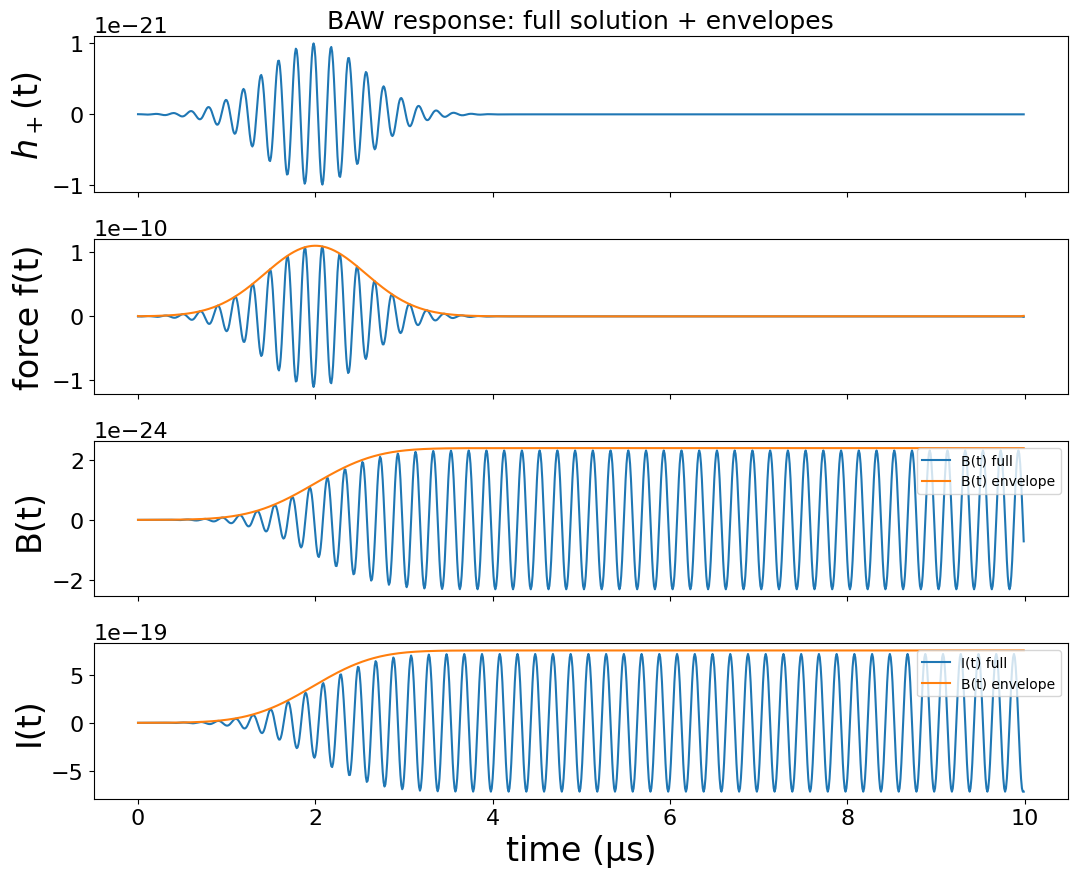

In [67]:
# -----------------------------
# Example time grid + strain
# -----------------------------
fs = 100e6              # sampling rate (Hz)
T  = 10e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# -----------------------------
# Build a simple strain: gated tone near resonance
# -----------------------------
f0 = baw.omega_lambda/(2*np.pi)
f_drive = f0 * 1.01                   # slight detuning
h0 = 1e-21
t_on, t_off = 2e-6, 10e-6

# Gaussian pulse
window = np.exp(-(t-t_on)**2/(8e-7**2))#0.5*(1+np.tanh((t - t_on)/edge)) * 0.5*(1+np.tanh((t_off - t)/edge))

h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

# -----------------------------
# Full solution (fast oscillations)
# -----------------------------
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# -----------------------------
# Envelope solution (complex envelopes)
# -----------------------------
omega_d_of_t = 2*np.pi*f_drive * np.ones_like(t)
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=omega_d_of_t,
    omega_c=None,
    use_hilbert=True,
)


# -----------------------------
# Plot: 4 subplots (strain, force, B, I)
# -----------------------------
fig, axs = plt.subplots(4, 1, figsize=(11, 9), sharex=True)

axs[0].plot(t*1e6, h_plus)
axs[0].set_ylabel("$h_+$(t)")
axs[0].set_title("BAW response: full solution + envelopes")

axs[1].plot(t*1e6, f_force_env_ref)
axs[1].plot(t*1e6, np.abs(F_env))
axs[1].set_ylabel("force f(t)")

axs[2].plot(t*1e6, B, label="B(t) full")
axs[2].plot(t*1e6, np.abs(A_t), label="B(t) envelope")
axs[2].set_ylabel("B(t)")
axs[2].legend(loc="upper right")

axs[3].plot(t*1e6, I, label="I(t) full")
axs[3].plot(t*1e6, np.abs(I_env), label="B(t) envelope")
axs[3].set_ylabel("I(t)")
axs[3].set_xlabel("time (µs)")
axs[3].legend(loc="upper right")

plt.tight_layout()

In [34]:
# -----------------------------
# Frequency sweep around omega0
# -----------------------------
fs = 100e6              # sampling rate (Hz)
T  = 10e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]
window = np.ones_like(t)#np.exp(-(t-t_on)**2/(5e-7**2))
# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e2,
    k_lambda=1e-2,
)

f0 = baw.omega_lambda / (2*np.pi)

Nf = 51
f_list = np.linspace(f0-1e6, f0+1e6, Nf)

I_full_map = np.zeros((Nf, len(t)))
I_env_map  = np.zeros((Nf, len(t)))


In [35]:
t0 = time.perf_counter()
for i, f_drive in enumerate(f_list):
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)

    B, Bdot, I, f_force = baw.solve_current(
        t,
        h_plus,
        use_green=True,
    )

    I_full_map[i, :] = np.abs(I)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} s")

Elapsed time: 6.598273 s


In [36]:
t0 = time.perf_counter()

for i, f_drive in enumerate(f_list):
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)
    omega_d_of_t = 2*np.pi * f_drive * np.ones_like(t)

    A_t, V_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
        t=t,
        h_plus=h_plus,
        omega_d_of_t=omega_d_of_t,
        omega_c=baw.omega_lambda,
        use_hilbert=True,
    )

    # reconstruct physical current magnitude
    I_env_map[i, :] =  np.abs(I_env)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} s")

Elapsed time: 0.057303 s


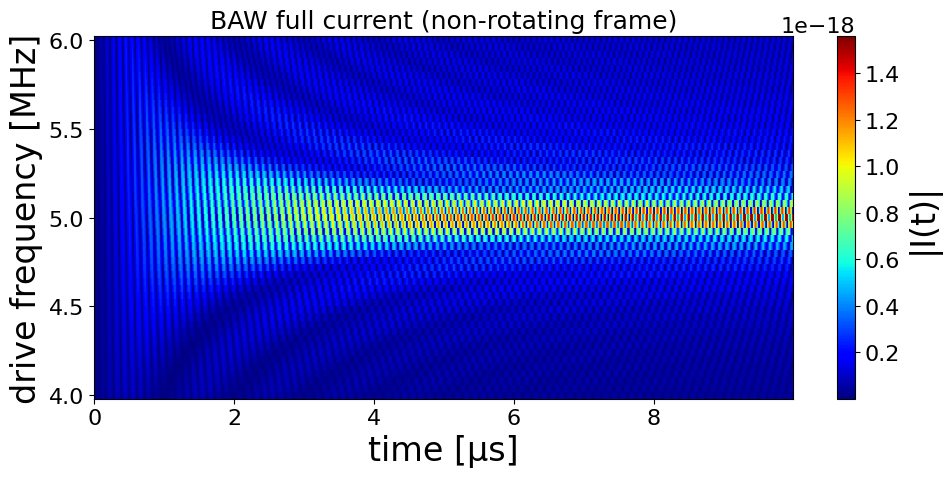

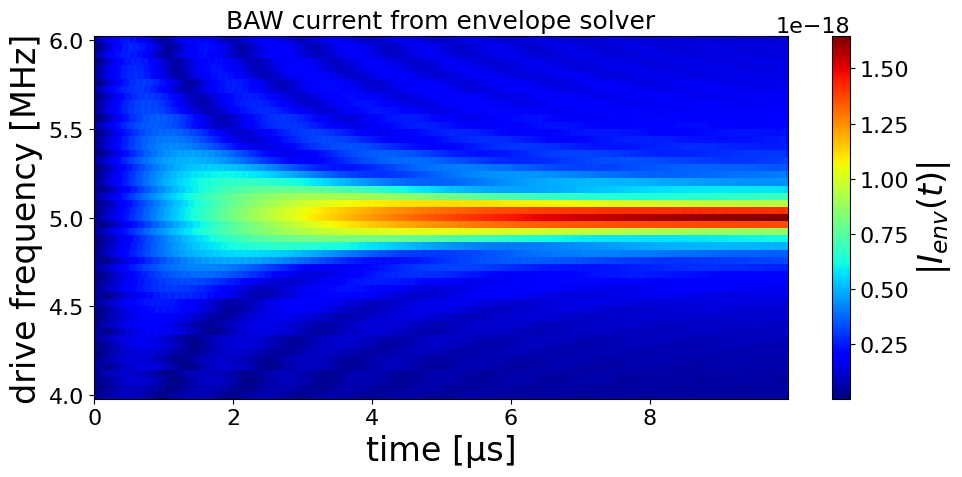

In [37]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(
    t*1e6,
    f_list*1e-6,
    I_full_map,
    shading="auto",
    cmap='jet'
)
plt.colorbar(label="|I(t)|")
plt.xlabel("time [µs]")
plt.ylabel("drive frequency [MHz]")
plt.title("BAW full current (non-rotating frame)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.pcolormesh(
    t*1e6,
    f_list*1e-6,
    I_env_map,
    shading="auto",
    cmap='jet'
)
plt.colorbar(label="$|I_{env}(t)|$")
plt.xlabel("time [µs]")
plt.ylabel("drive frequency [MHz]")
plt.title("BAW current from envelope solver")
plt.tight_layout()
plt.show()


In [64]:
# -----------------------------
# Frequency sweep around omega0
# -----------------------------
fs = 100e6              # sampling rate (Hz)
T  = 5e-5             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]
window = np.ones_like(t)# np.exp(-(t-t_on)**2/(5e-7**2))
# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e6,
    k_lambda=1e-2,
)

f0 = baw.omega_lambda / (2*np.pi)

Nf = 201
f_list = np.linspace(f0-5e5, f0+5e5, Nf)

I_full_map = np.zeros((Nf, len(t)))
I_env_map  = np.zeros((Nf, len(t)))


t0 = time.perf_counter()
print(f'{0/len(f_list)*100:.2f} %', end='\r')
for i, f_drive in enumerate(f_list):
    
    h_plus = h0 * window * np.cos(2*np.pi*f_drive*t)
    omega_d_of_t = 2*np.pi * f_drive * np.ones_like(t)

    A_t, V_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
        t=t,
        h_plus=h_plus,
        omega_d_of_t=omega_d_of_t,
        omega_c=baw.omega_lambda,
        use_hilbert=True,
    )
    print(f'{(i+1)/len(f_list)*100:.2f} %', end='\r')

    # reconstruct physical current magnitude
    I_env_map[i, :] =  np.abs(I_env)
dt = time.perf_counter() - t0
print(f"Elapsed time: {dt:.6f} s")

Elapsed time: 0.913749 s


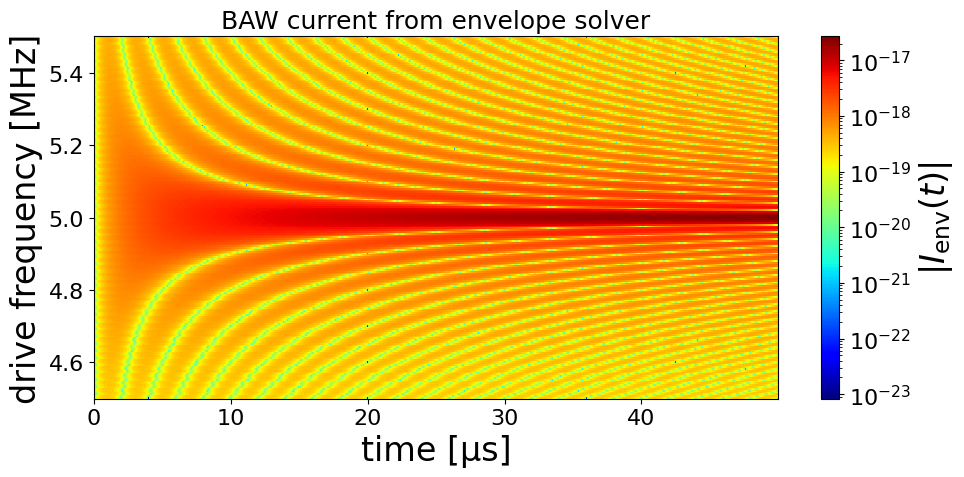

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))

pcm = ax.pcolormesh(
    t * 1e6,
    f_list * 1e-6,
    np.abs(I_env_map),
    shading="auto",
    cmap='jet',
    norm=LogNorm()
)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r"$|I_{\mathrm{env}}(t)|$")

ax.set_xlabel("time [µs]")
ax.set_ylabel("drive frequency [MHz]")
ax.set_title("BAW current from envelope solver")


fig.tight_layout()

# Chirp force

In [8]:
# -----------------------------
# Example time grid + strain
# -----------------------------
fs = 100e6              # sampling rate (Hz)
T  = 100e-6             # total duration (s)
N  = int(T * fs)
t  = np.linspace(0.0, T, N, endpoint=False)
dt = t[1] - t[0]

# -----------------------------
# Example BAW mode
# -----------------------------
baw = BAWMode(
    n=3,
    d=1e-3,
    eta_x=0.12,
    eta_y=0.12,
    omega_lambda=2*np.pi*5e6,   # 5 MHz
    Q=1e7,
    k_lambda=1e-2,
)

# -----------------------------
# Build a simple strain: gated tone near resonance
# -----------------------------
f0 = baw.omega_lambda/(2*np.pi)
h0 = 1e-21


h_plus, f_t = chirp_with_window(t, f_start=4e6, f_end=10e6, t_start=t[0], t_end=t[-1], envelope=np.ones_like(t)*h0)#h0 * window * np.cos(2*np.pi*f_drive*t)
omega_d_of_t = 2*np.pi*f_t * np.ones_like(t)

# -----------------------------
# Full solution (fast oscillations)
# -----------------------------
B, Bdot, I, f_force = baw.solve_current(t, h_plus, use_green=True)

# -----------------------------
# Envelope solution (complex envelopes)
# -----------------------------
A_t, Adot_t, I_env, f_force_env_ref, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=omega_d_of_t,
    omega_c=None,
    use_hilbert=True,
)
# Envelope for displacement and current (for overlay): use magnitude
B_env = 2*np.abs(A_t)         # since B(t) ≈ 2 Re[A e^{-iω_ct}]
I_env_mag = 2*np.abs(I_env)   # since I(t) ≈ 2 Re[I_env e^{-iω_ct}]

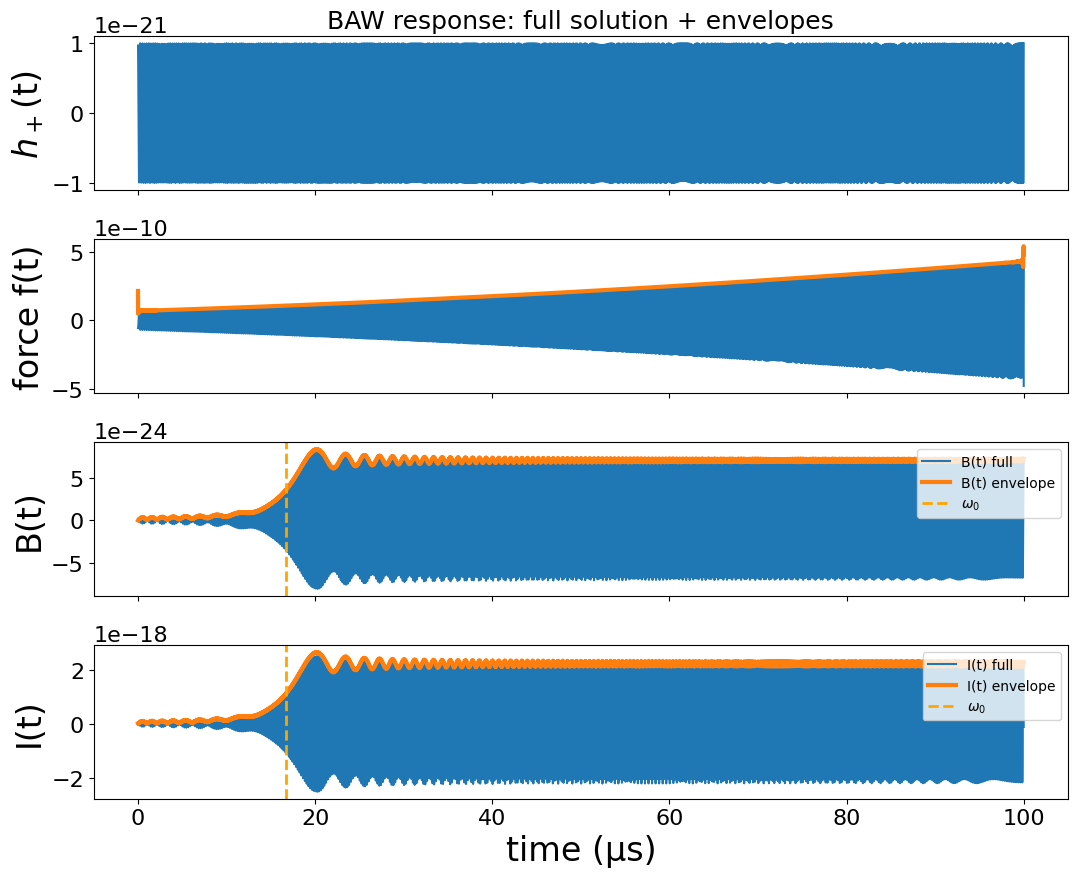

In [9]:
# -----------------------------
# Plot: 4 subplots (strain, force, B, I)
# -----------------------------
fig, axs = plt.subplots(4, 1, figsize=(11, 9), sharex=True)
t_f0 = time_at_frequency(t, omega_d_of_t, [baw.omega_lambda - baw.gamma_lambda, baw.omega_lambda, baw.omega_lambda + baw.gamma_lambda])


axs[0].plot(t*1e6, h_plus)
axs[0].set_ylabel("$h_+$(t)")
axs[0].set_title("BAW response: full solution + envelopes")

axs[1].plot(t*1e6, f_force_env_ref)
axs[1].plot(t*1e6, np.abs(F_env), lw=3)
axs[1].set_ylabel("force f(t)")

axs[2].plot(t*1e6, B, label="B(t) full")
axs[2].plot(t*1e6, np.abs(A_t), label="B(t) envelope", lw=3)
axs[2].axvline(t_f0[0]*1e6, color='orange', lw=2, ls='--', label=r'$\omega_0$')
axs[2].set_ylabel("B(t)")
axs[2].legend(loc="upper right")

axs[3].plot(t*1e6, I, label="I(t) full")
axs[3].plot(t*1e6, np.abs(I_env), label="I(t) envelope", lw=3)
axs[3].axvline(t_f0[0]*1e6, color='orange', lw=2, ls='--', label=r'$\omega_0$')
axs[3].set_ylabel("I(t)")
axs[3].set_xlabel("time (µs)")
axs[3].legend(loc="upper right")

plt.tight_layout()